In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch

from bliss.datasets import sdss

In [2]:
import sys
sys.path.insert(0, '../sdss_galaxies/')
from sparse_field_lib import load_data

In [3]:
sys.path.insert(0, './utils')
import source_simulator_lib
import catalog_optimizer_lib
from plotting_utils import plot_residuals

from which_device import device

In [4]:
sdss_dir = '/home/runingli/astronomy/celeste/data/sdss/'
psf_file = sdss_dir + '/94/1/12/psField-000094-1-0012.fits'

# Load PSF

In [5]:
sdss_psf = sdss.SdssPSF(psf_file, [2])

psf = sdss_psf.psf_at_points(0, 0., 0.)

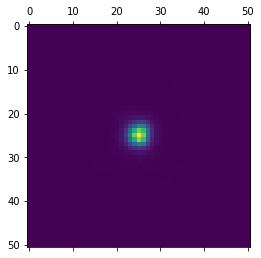

In [6]:
%matplotlib inline
plt.matshow(psf)

# Simulate an image

In [7]:
slen = 100

max_sources = 2

background = torch.zeros((1, 1, slen, slen), device = device) + 800.

In [8]:
locs = torch.rand((1, max_sources,2), device = device)

fmin = 5000.
fmax = 6000.
star_fluxes = torch.rand((1, max_sources,1), device = device) * (fmin - fmax) + fmin
gal_fluxes = torch.rand((1, max_sources,1), device = device) * (fmin - fmax) + fmin


theta = torch.rand((1, max_sources,1), device = device) * 2 * np.pi
ell = torch.rand((1, max_sources,1), device = device) * 0.8 + 0.2
rad = torch.rand((1, max_sources,1), device = device) * 2 + 1

star_bool = torch.Tensor([[1, 0]]).unsqueeze(-1).to(device)
gal_bool = torch.Tensor([0, 1]).unsqueeze(-1).to(device)

galaxy_params = dict(flux = gal_fluxes, 
                     theta = theta, 
                     ell = ell, 
                     rad = rad)

In [9]:
_psf = torch.Tensor(psf).unsqueeze(0).to(device)

source_simulator = source_simulator_lib.SourceSimulator(psf = _psf, 
                                                        tile_slen = slen - 40, 
                                                        ptile_slen = slen)

In [10]:
gal = source_simulator.render_galaxies(locs, 
                                       galaxy_params, 
                                       gal_bool)

star = source_simulator.render_stars(locs, 
                                    star_fluxes, 
                                    star_bool)

In [11]:
image = gal + star + background
image += torch.randn(image.shape, device = device) * torch.sqrt(image)

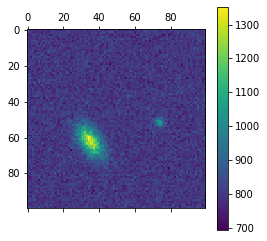

In [12]:
plt.matshow(image[0, 0].cpu())
plt.colorbar()

# Start from random init and optimize

In [13]:
fluxes_init = torch.rand((1, max_sources,1), device = device) * (fmin - fmax) + fmin

In [14]:
my_catalog = catalog_optimizer_lib.CatalogParameters(locs, 
                                                     fluxes_init).to(device)

### initial loss

In [15]:
loss, recon_mean0 = catalog_optimizer_lib.get_loss(image, 
                                                  background,
                                                  source_simulator,
                                                  my_catalog,
                                                  star_bool, 
                                                  gal_bool)

print(loss)

tensor(5.2064, device='cuda:4', grad_fn=<NegBackward>)


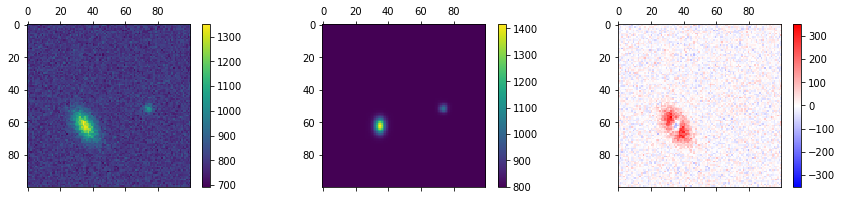

In [16]:
plot_residuals(image, recon_mean0);

### Optimize

In [17]:
catalog_optimizer_lib.estimate_catalog(image, 
                                       background,
                                       source_simulator,
                                       my_catalog,
                                       star_bool, 
                                       gal_bool, 
                                       lr = 1,
                                       print_every = True)

tensor(5.2064, device='cuda:4', grad_fn=<NegBackward>)
tensor(4.7671, device='cuda:4', grad_fn=<NegBackward>)
tensor(4.7671, device='cuda:4', grad_fn=<NegBackward>)
tensor(4.7671, device='cuda:4', grad_fn=<NegBackward>)


### Final loss

In [18]:
loss, recon_mean = catalog_optimizer_lib.get_loss(image, 
                               background,
                               source_simulator,
                               my_catalog,
                               star_bool, 
                               gal_bool)

print(loss)

tensor(4.7671, device='cuda:4', grad_fn=<NegBackward>)


(<Figure size 1080x216 with 6 Axes>,
 array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>], dtype=object))

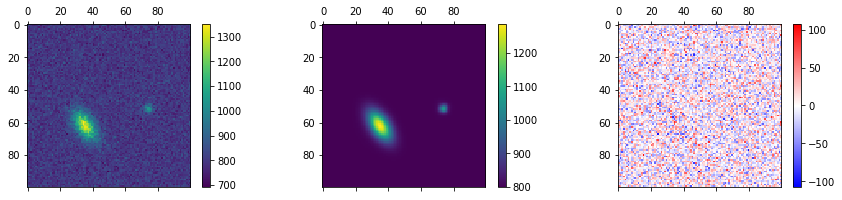

In [19]:
plot_residuals(image, recon_mean)